In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin

import csv
import pandas as pd
import numpy as np


In [2]:
# Read data

X = pd.read_csv("ml_case_training_data.csv")
Y = pd.read_csv("ml_case_training_output.csv")

X['to_pred'] = 0
Y['to_pred'] = 0

X_to_pred = pd.read_csv("ml_case_test_data.csv")
Y_to_pred = pd.read_csv("ml_case_test_output_template.csv")

X_to_pred['to_pred'] = 1
Y_to_pred['to_pred'] = 1

X_comb = pd.concat([X, X_to_pred])
Y_comb = pd.concat([Y, Y_to_pred])

X = X.drop('to_pred',1)
Y = Y.drop('to_pred',1)
X_to_pred = X_to_pred.drop('to_pred',1)
Y_to_pred = Y_to_pred.drop('to_pred',1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [3]:
X['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7825
kamkkxfxxuwbdslkwifmmcsiusiuosws    4517
ldkssxwpmemidmecebumciepifcamkci    3664
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [4]:
# Check if 'id' of X_comb matches 'id' of Y_comb by rows

pd.DataFrame(X_comb['id'] == Y_comb['id']).count()['id'] == len(X_comb)

True

In [5]:
# Check if 'id' is unique in X_comb (and then in Y_comb as well)
print(X_comb.count()['id'] == len(X_comb))
print(X_comb.count()['id'], 'samples in total')

True
20120 samples in total


In [6]:
# Let's look at the number of missing values in each column in X_comb
X_comb.count()

id                          20120
activity_new                 8221
campaign_disc_ele               0
channel_sales               14846
cons_12m                    20120
cons_gas_12m                20120
cons_last_month             20120
date_activ                  20120
date_end                    20118
date_first_activ             4385
date_modif_prod             19918
date_renewal                20076
forecast_base_bill_ele       4385
forecast_base_bill_year      4385
forecast_bill_12m            4385
forecast_cons                4385
forecast_cons_12m           20120
forecast_cons_year          20120
forecast_discount_energy    19970
forecast_meter_rent_12m     20120
forecast_price_energy_p1    19970
forecast_price_energy_p2    19970
forecast_price_pow_p1       19970
has_gas                     20120
imp_cons                    20120
margin_gross_pow_ele        20105
margin_net_pow_ele          20105
nb_prod_act                 20120
net_margin                  20102
num_years_anti

In [46]:
# Because 'campaign_disc_ele' is empty, we can remove it
X_comb = X_comb.drop('campaign_disc_ele',1)

In [47]:
# Positions of columns which have half values missing
pos = [ i for i in range(len(list(X_comb))) if list(X_comb.count())[i] <= len(X_comb)/2  ]

# Get the name of these columns above
col_half_miss = [list(X_comb)[i] for i in pos ]
print(col_half_miss)

# Drop these columns from X
X_comb = X_comb.drop(col_half_miss, 1)

['activity_new', 'date_first_activ', 'forecast_base_bill_ele', 'forecast_base_bill_year', 'forecast_bill_12m', 'forecast_cons']


In [48]:
# Remark that we have four columns of date information of 
# activation/end of the customers' contracts. The five columns
# are 'date_activ', 'date_end', 'date_modif_prod', and 'date_renewal'.
# Labeling these four columns and then directly use them in training is not the
# best option. On the other hand, doing one-hot encoding is too expensive for these 
# columns. Hence we seek for an alternative, i.e. to convert these information to numerical ones.

# Comparing 'date_activ' and 'date_modif_prod' gives whether a customer has changed the product
col_prod_changed = pd.DataFrame(X['date_activ'] == X['date_modif_prod'],columns=['prod_changed'])

# uncomment the lines below to comput prob1 and prob2 
index_prod_changed = [ i for i in range(len(col_prod_changed)) if list(col_prod_changed['prod_changed'])[i]==True ]
index_prod_unchanged = [ i for i in range(len(col_prod_changed)) if list(col_prod_changed['prod_changed'])[i]==False]

index_churn = [i for i in range(len(Y)) if list(Y['churn'])[i] == 1]
index_not_churn = [i for i in range(len(Y)) if list(Y['churn'])[i] == 0]

In [49]:
# The probability of having products changed or not, over all customers
prob_changed_in_whole = len(index_prod_changed)/(len(index_prod_changed) + len(index_prod_unchanged)*1.0)
prob_unchanged_in_whole = 1-prob_changed_in_whole
prob_changed_in_whole, prob_unchanged_in_whole

(0.496148111332008, 0.503851888667992)

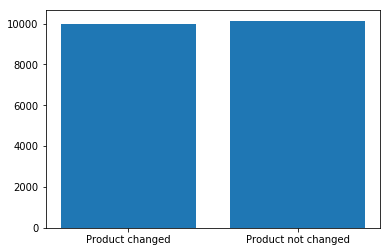

In [50]:
import matplotlib.pyplot as plt
plt.bar(['Product changed','Product not changed'],[prob_changed_in_whole*20120,prob_unchanged_in_whole*20120])
# plt.title('Probability of changing product for all customers')
plt.show()

In [51]:
# The probability of having products changed or not, over all customers who churn 
prob_changed_in_churn = len(set(index_prod_changed) & set(index_churn)) / (1.0 * len(index_churn) )
prob_unchanged_in_churn = 1 - prob_changed_in_churn
prob_changed_in_churn, prob_unchanged_in_churn

(0.43009404388714734, 0.5699059561128527)

In [52]:
# The probability of having products changed or not, over all customers who don't churn 
prob_changed_in_notchurn = len(set(index_prod_changed) & set(index_not_churn)) / (1.0 * len(index_not_churn) )
prob_unchanged_in_notchurn = 1 - prob_changed_in_notchurn
prob_changed_in_notchurn, prob_unchanged_in_notchurn

(0.5034135576856769, 0.49658644231432314)

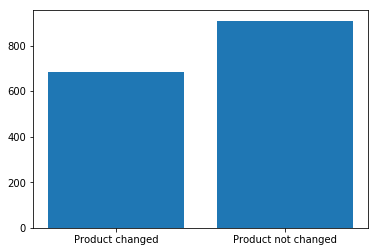

In [53]:
import matplotlib.pyplot as plt
plt.bar(['Product changed','Product not changed'],[prob_changed_in_churn*1595,prob_unchanged_in_churn*1595])
# plt.title('Probability of changing product for churning customers')
plt.show()

In [54]:
# We can see that for the customers who churn, there is a visible trend 
# on that these customers may also have their product unchanged ever
# Hence we use the column of having changed product or not, i.e. 'col_prod_changed', as a feature of training

col_prod_changed = pd.DataFrame(X_comb['date_activ'] == X_comb['date_modif_prod'],columns=['prod_changed'])

X_comb = pd.concat([X_comb, col_prod_changed], axis = 1)

In [55]:
# We then drop the  time information
X_comb = X_comb.drop(['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'], 1)

In [56]:
# We clean the null values in X. If a column is categorical, 
# then the null values are replaced by the most frequent value, 
# otherwise it is replaced by the mean of the column.

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

X_comb = DataFrameImputer().fit_transform(X_comb)

In [57]:
# We have several categorical columns 'channel_sales' and 'origin_up'.
# They are encoded with labels, and then transformed to be corresponding one-hot labels.

onehot_columns = ['origin_up','channel_sales', 'prod_changed','has_gas','nb_prod_act', 'num_years_antig']

In [58]:
# Normalization of X
from sklearn.preprocessing import normalize
X_norm = X_comb.drop(onehot_columns,1)
X_norm = X_norm.drop(['id','to_pred'],1)
X_norm = pd.DataFrame(normalize(X_norm), columns = X_norm.columns, index=X_comb.index)

In [59]:
# Scaling
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_norm = pd.DataFrame(ss.fit_transform(X_norm), columns = X_norm.columns, index=X_comb.index)
X_norm = pd.DataFrame(X_norm, columns = X_norm.columns, index=X_comb.index)

In [60]:
X_comb = pd.concat([X_norm, X_comb.drop(X_norm.columns,1)],1)

In [61]:
X_comb = pd.get_dummies(X_comb, columns=onehot_columns)

In [62]:
X_labeled = X_comb[X_comb['to_pred']==0]
X_to_pred = X_comb[X_comb['to_pred']==1]
y_labeled = Y_comb[X_comb['to_pred']==0]
y_to_pred = Y_comb[X_comb['to_pred']==1]

In [63]:
X = X_labeled.drop(['to_pred','id'],1)
Y = y_labeled[['churn']]

Class Churn: 1595
Class Not-Churn: 14501
Proportion: 9.0915 : 1


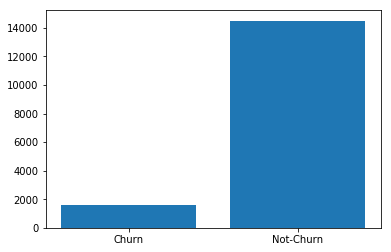

In [64]:
# Split data set by classes (i.e. churn or not)
# One can observe that how imbalance the data set is. 
X_churn = X.loc[Y['churn'] == 1]
Y_churn = Y.loc[Y['churn'] == 1]

X_not_churn = X.loc[Y['churn'] == 0]
Y_not_churn = Y.loc[Y['churn'] == 0]

print('Class Churn:', len(X_churn))
print('Class Not-Churn:', len(X_not_churn))
print('Proportion:', round(len(X_not_churn) /(len(X_churn)*1.0), 4), ': 1')

import matplotlib.pyplot as plt
plt.bar(['Churn','Not-Churn'],[len(X_churn),len(X_not_churn)])
plt.show()

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=43)

In [66]:
# classifier comparison
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression


In [67]:
names = [
    "Nearest Neighbors", 
#     "Linear SVM", 
#     "RBF SVM",
    "Decision Tree",
    "Logistic Regression",
    "Random Forest",  
    "Naive Bayes", 
    "QDA",
    "Bagging",
    "AdaBoost"
]

classifiers = [
    KNeighborsClassifier(),
#     SVC(kernel="linear"),
#     SVC(),
    DecisionTreeClassifier(max_depth=4),
    LogisticRegression(),
    RandomForestClassifier(max_depth=4),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    BaggingClassifier(),
    AdaBoostClassifier()
]

parameters = [
    {'n_neighbors': [1,2,3]}, # Nearest Neighbors
#     {'C': [0.01, 0.025, 0.5, 0.1]}, # Linear SVM
#     {'C': [1, 1.5, 3, 7], 'gamma': [1, 2,3]}, # RBF SVM
    {'max_depth':[2,4,8]}, # Decision Tree
    {'C': [1,5,10]}, # Logistic Regression
    {'max_depth': [8, 16, 32], 'min_samples_leaf':[2, 4, 8]}, # Random Forest
    {}, # Naive Bayes
    {}, # QDA
    {'n_estimators':[5,10,15,20,25],'base_estimator':[]}, # Bagging
    {'n_estimators':[2,3,4],'base_estimator':[]} # AdaBoost
]

best_classifiers = []

for name, clf, par in zip(names, classifiers, parameters):
    print(name, 'Training ... ')
    clf.fit(X_train,y_train.values.ravel())
        
    clf_best = GridSearchCV(estimator=clf,param_grid=par,cv=5,scoring='accuracy')
    clf_best.fit(X_train,y_train.values.ravel())
    
    best_classifiers.append(clf_best)
    
    if name in ['Decision Tree','Random Forest']:
        parameters[names.index('Bagging')]['base_estimator'].append(clf_best.best_estimator_)
        parameters[names.index('AdaBoost')]['base_estimator'].append(clf_best.best_estimator_)

    print('Finished!')
    
    

Nearest Neighbors Training ... 
Finished!
Decision Tree Training ... 
Finished!
Logistic Regression Training ... 


/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 

Finished!
Random Forest Training ... 


/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Finished!
Naive Bayes Training ... 
Finished!
QDA Training ... 


/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

Finished!
Bagging Training ... 
Finished!
AdaBoost Training ... 
Finished!


In [68]:
# score and report by Holdout

tp_score_list = []

for name, clf_best in zip(names, best_classifiers): 
    score = clf_best.score(X_test, y_test)

    clf_best_pred = clf_best.predict(X_test)

    print('The Holdout accuracy of', name, 'is', score)
    print(classification_report(y_true = y_test,y_pred = clf_best_pred))
    
    predicted_churn = sum(clf_best_pred)
    correct_predicted_churn = len(set([i for i, x in enumerate(clf_best_pred) if x == 1]) & set ([i for i, x in enumerate(y_test.values.ravel()) if x == 1]))

    print('predicted_churn', predicted_churn)
    print('correct_predicted_churn', correct_predicted_churn)
    
    if predicted_churn == 0:
        tp_score = 0
    else:
        tp_score = correct_predicted_churn / (1.0 * predicted_churn)
    tp_score_list.append(tp_score)
    


The Holdout accuracy of Nearest Neighbors is 0.8913043478260869
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      2878
         1.0       0.43      0.07      0.12       342

   micro avg       0.89      0.89      0.89      3220
   macro avg       0.66      0.53      0.53      3220
weighted avg       0.85      0.89      0.85      3220

predicted_churn 56.0
correct_predicted_churn 24
The Holdout accuracy of Decision Tree is 0.8937888198757764
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      2878
         1.0       0.50      0.00      0.01       342

   micro avg       0.89      0.89      0.89      3220
   macro avg       0.70      0.50      0.47      3220
weighted avg       0.85      0.89      0.84      3220

predicted_churn 2.0
correct_predicted_churn 1
The Holdout accuracy of Logistic Regression is 0.8937888198757764
              precision    recall  f1-score   support

       

/anaconda3/envs/Py3_R/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      2878
         1.0       1.00      0.01      0.02       342

   micro avg       0.89      0.89      0.89      3220
   macro avg       0.95      0.50      0.48      3220
weighted avg       0.91      0.89      0.85      3220

predicted_churn 3.0
correct_predicted_churn 3
The Holdout accuracy of AdaBoost is 0.8987577639751553
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      2878
         1.0       0.90      0.05      0.10       342

   micro avg       0.90      0.90      0.90      3220
   macro avg       0.90      0.53      0.52      3220
weighted avg       0.90      0.90      0.86      3220

predicted_churn 20.0
correct_predicted_churn 18


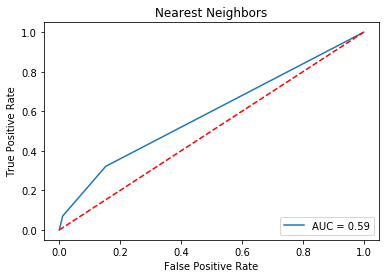

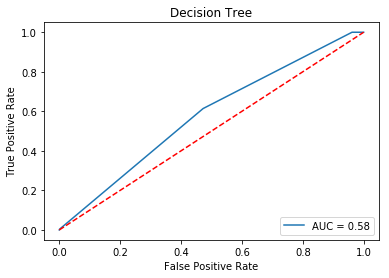

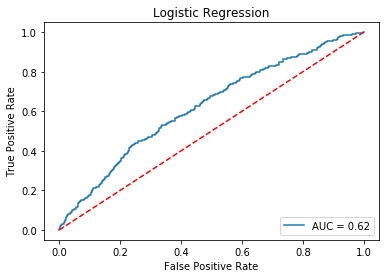

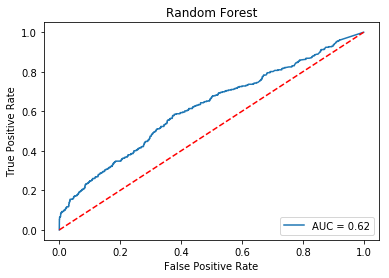

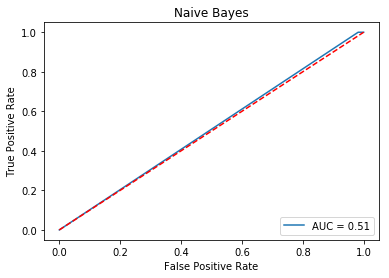

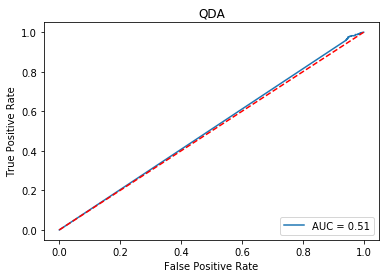

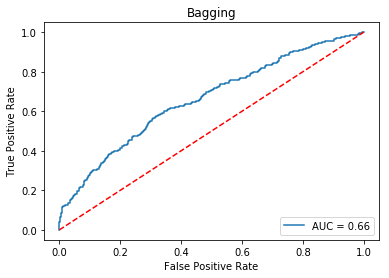

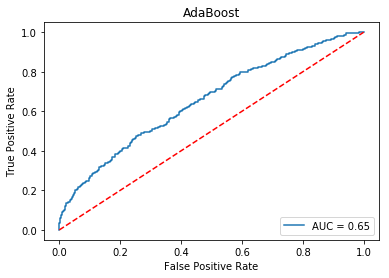

In [69]:
# Evaluating classifiers by ROC

X_roc = X_test
y_roc = y_test

auc_list = []
for i in range(len(names)):
    pred_prob = best_classifiers[i].predict_proba(X_roc)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_roc, pred_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)    
    plt.title(names[i])
    plt.plot(false_positive_rate, true_positive_rate,
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    auc_list.append(roc_auc)
    
ranked_inx = list(reversed(np.argsort(auc_list)))    

In [70]:
X_to_pred_format = X_to_pred.drop(['id','to_pred'],1)

selected_clf_inx = ranked_inx[0]
# selected_clf = best_classifiers[selected_clf_inx]

# pred = selected_clf.predict(X_to_pred_format)
# pred_prob = selected_clf.predict_proba(X_to_pred_format)

# y_to_pred['predicted'] = pred
# y_to_pred['Churn_probability'] = pred_prob[:,1]
# y_to_pred.index = range(1,len(y_to_pred)+1) 

print('The best estimator is', names[selected_clf_inx])
# print 'Churning estimation by', names[selected_clf_inx], ':'
# print y_to_pred[y_to_pred['predicted']==1.0][['id','Churn_probability']].sort_values(by='Churn_probability', ascending=False)

The best estimator is Bagging


In [71]:
# Now we know the best classifier. 
# We then train the classifier on the whole labeled dataset X.

clf = classifiers[selected_clf_inx]
par = parameters[selected_clf_inx]

# fit the classifier with all labeled data
clf.fit(X,Y.values.ravel())
clf_best = GridSearchCV(estimator=clf,param_grid=par,cv=5,scoring='accuracy')
clf_best.fit(X,Y.values.ravel())


pred = clf_best.predict(X_to_pred_format)
pred_prob = clf_best.predict_proba(X_to_pred_format)

y_to_pred['Churn_prediction'] = map(int, list(pred))
y_to_pred['Churn_probability'] = pred_prob[:,1]
y_to_pred.index = range(1,len(y_to_pred)+1) 

print('Churning estimation by', names[selected_clf_inx])
print(y_to_pred[y_to_pred['Churn_prediction']==1.0][['id','Churn_probability']].sort_values(by='Churn_probability', ascending=False))

Churning estimation by Bagging
Empty DataFrame
Columns: [id, Churn_probability]
Index: []


/anaconda3/envs/Py3_R/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda3/envs/Py3_R/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
rf = classifiers[names.index('Random Forest')]
rf_par = parameters[names.index('Random Forest')]

# fit the classifier with all labeled data
rf.fit(X,Y.values.ravel())
rf_best = GridSearchCV(estimator=rf,param_grid=rf_par,cv=5,scoring='accuracy')
rf_best.fit(X,Y.values.ravel())

# We use random forest to rank the importance of features.
estimator = rf

importances = estimator.feature_importances_

mean = np.mean([tree.feature_importances_ for tree in estimator.estimators_],
             axis=0)

print("Feature importance:")
print("")

X_train_lst = []
for column in X_train:
     X_train_lst.append(column)

X_train_ser = pd.Series(X_train_lst)
        

feature_imp = pd.DataFrame(
{'Feature':X_train_ser,
 'Importance':mean})

feature_imp.sort_values(by='Importance',inplace=True,ascending=False)
print(pd.DataFrame(feature_imp))


Feature importance:

                                           Feature  Importance
19      origin_up_lxidpiddsbxsbosboudacockeimpuepw    0.114864
7                         forecast_price_energy_p1    0.102863
13                                      net_margin    0.093230
9                            forecast_price_pow_p1    0.076608
8                         forecast_price_energy_p2    0.068001
48                               num_years_antig_6    0.064425
0                                         cons_12m    0.048161
14                                         pow_max    0.047715
2                                  cons_last_month    0.045710
12                              margin_net_pow_ele    0.045320
17      origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws    0.041333
4                               forecast_cons_year    0.040783
3                                forecast_cons_12m    0.028039
1                                     cons_gas_12m    0.026874
10                                

In [73]:
y_output = y_to_pred[['Unnamed: 0','id','Churn_probability','Churn_prediction']].sort_values(by='Churn_probability', ascending=False)
y_output = y_output.rename(columns = {'Unnamed: 0':''})

In [74]:
y_output.to_csv('ml_case_test_output.csv',index=False)

In [75]:
X_raw_test = pd.read_csv("ml_case_test_data.csv")

X_raw_test['Churn_prediction'] = y_to_pred['Churn_prediction']
X_raw_test['Churn_probability'] = y_to_pred['Churn_probability']

In [76]:
sheet = X_raw_test[X_raw_test['Churn_prediction']==1]

In [77]:
# Inspecting the electricity campaigns of all churning customers
sheet[sheet['Churn_prediction']==1]['origin_up'].value_counts()

Series([], Name: origin_up, dtype: int64)

In [78]:
# Get those churn customers
churn_customers = list(sheet.index)

In [79]:
from datetime import datetime
from dateutil import parser, relativedelta

jan_1_2018 = datetime(2018,1,1,0,0)
jan_1_2017 = datetime(2017,1,1,0,0)

contract_end = []
for customer in churn_customers:
    dt = parser.parse(list(sheet[['date_end']].loc[customer])[0])
    one_month = relativedelta.relativedelta(months=1)
    if dt.day > 15:
        dt = dt + one_month  
    contract_end.append(dt.replace(day = 1))

In [80]:
next_contract_end = []
for dt in contract_end:
    next_contract_end.append(dt.replace(year = dt.year+1))

In [81]:
from dateutil.rrule import rrule, MONTHLY

months_betw_contracts_2016= []
months_betw_contracts_2017 = []

for i in range(len(churn_customers)):
    date1 = contract_end[i]
    date2 = next_contract_end[i]
    months_2016 = [dt for dt in rrule(MONTHLY, dtstart=date1, until=jan_1_2017)]
    months_2017 = [dt for dt in rrule(MONTHLY, dtstart=jan_1_2017, until=date2)]
    months_2016 = months_2016[:-1]
    months_2017 = months_2017[:-1]
    months_2016 = len(months_2016)
    months_2017 = len(months_2017)
    months_betw_contracts_2016.append(months_2016)
    months_betw_contracts_2017.append(months_2017)

In [82]:
months_after_new_contract_2017 = []

for i in range(len(churn_customers)):
    date1 = next_contract_end[i]
    date2 = jan_1_2018
    months_2017 = [dt for dt in rrule(MONTHLY, dtstart=date1, until=jan_1_2018)]
    months_2017 = months_2017[:-1]
    months_2017 = len(months_2017)
    months_after_new_contract_2017.append(months_2017)


In [83]:
X_hist_test = pd.read_csv("ml_case_test_hist_data.csv")

In [84]:
p1_var_avg_list = []
p2_var_avg_list = []
p3_var_avg_list = []

p1_fix_avg_list = []
p2_fix_avg_list = []
p3_fix_avg_list = []

for customer in churn_customers:
    customer_id = sheet.loc[customer]['id']
    
    p1_var_avg = np.mean(X_hist_test[X_hist_test['id']==customer_id]['price_p1_var'])
    p2_var_avg = np.mean(X_hist_test[X_hist_test['id']==customer_id]['price_p2_var'])
    p3_var_avg = np.mean(X_hist_test[X_hist_test['id']==customer_id]['price_p3_var'])
    
    p1_var_avg_list.append(p1_var_avg)
    p2_var_avg_list.append(p2_var_avg)
    p3_var_avg_list.append(p3_var_avg)
    
    p1_fix_avg = np.mean(X_hist_test[X_hist_test['id']==customer_id]['price_p1_fix'])
    p2_fix_avg = np.mean(X_hist_test[X_hist_test['id']==customer_id]['price_p2_fix'])
    p3_fix_avg = np.mean(X_hist_test[X_hist_test['id']==customer_id]['price_p3_fix'])
    
    p1_fix_avg_list.append(p1_fix_avg)
    p2_fix_avg_list.append(p2_fix_avg)
    p3_fix_avg_list.append(p3_fix_avg)

var_avg_list = [ x+y+z for x,y,z in zip(p1_var_avg_list,p2_var_avg_list,p3_var_avg_list) ]
fix_avg_list = [ x+y+z for x,y,z in zip(p1_fix_avg_list,p2_fix_avg_list,p3_fix_avg_list) ]

In [85]:
b_list = []
c_list = []

for customer in churn_customers:
    
    if sheet.loc[customer]['cons_12m'] == 0:
        ratio_feb_to_dec = 1
    else:
        ratio_feb_to_dec = 1- sheet.loc[customer]['cons_last_month']/sheet.loc[customer]['cons_12m']
    
    cons_avg_month_2016 = (sheet.loc[customer]['forecast_cons_12m' ]*ratio_feb_to_dec)/11.0
    cons_avg_month_2017 = (sheet.loc[customer]['forecast_cons_year'])/12.0
    
#     print(cons_avg_month_2016, cons_avg_month_2017)
    
    inx = churn_customers.index(customer)
    
    cons_2016_part_b = cons_avg_month_2016 * months_betw_contracts_2016[inx]
    cons_2017_part_b = cons_avg_month_2017 * months_betw_contracts_2017[inx]
    
    # cons_part_b gives the total consumption of electricity in both 2016 and 2017 before the end of next 12-months contract
    cons_part_b = cons_2016_part_b + cons_2017_part_b
    
    b_var = cons_part_b * var_avg_list[inx]
    b_fix = fix_avg_list[inx] * (months_betw_contracts_2016[inx] + months_betw_contracts_2017[inx])
    revenue_b = b_var + b_fix
    
    net_margin = sheet.loc[customer]['margin_net_pow_ele' ]/100.0
    b = revenue_b * net_margin
    
    # cons_part_b gives the total consumption of electricity after the next 12-months contract in 2017 
    cons_part_c = cons_avg_month_2017 * months_after_new_contract_2017[inx]
    c_var = cons_part_c * var_avg_list[inx]
    c_fix = fix_avg_list[inx] * months_after_new_contract_2017[inx]
    revenue_c = c_var + c_fix
    
    c = revenue_c * net_margin
    
    b_list.append(b)
    c_list.append(c)

In [86]:
discount_customers = []
for customer in churn_customers:
    churn_prob = sheet.loc[customer]['Churn_probability']
    inx = churn_customers.index(customer)
    
    profit_discount = 0.8 * b_list[inx] + c_list[inx]
    profit_no_discount = (1-churn_prob)*(b_list[inx]+c_list[inx])
    
#     print(profit_no_discount, profit_discount)
        
    if profit_no_discount < profit_discount:
        discount_customers.append(customer)


In [87]:
# Below are the customers who churn
churn_customers

[]

In [88]:
# Below are the customers who should be given a discount
discount_customers

[]

In [89]:
# Customers who should be given a discount, in table form
print(sheet.loc[discount_customers][['id','Churn_probability']].sort_values(by='Churn_probability', ascending=False))

Empty DataFrame
Columns: [id, Churn_probability]
Index: []


In [90]:
# Profit b+c

total_profit_no_discount = 0
total_profit_all_discount = 0
total_profit_opt_discount = 0
total_profit_ideal = 0

for customer in churn_customers:
    inx = churn_customers.index(customer)
    profit_discount = 0.8 * b_list[inx] + c_list[inx]
    profit_no_discount = (1-churn_prob)*(b_list[inx]+c_list[inx])
    profit_ideal = b_list[inx] + c_list[inx]
    
    total_profit_no_discount += profit_no_discount
    total_profit_all_discount += profit_discount
    total_profit_opt_discount += max(profit_no_discount, profit_discount)
    total_profit_ideal += profit_ideal
    
print('The following profits are calculated only for the churning customers:')
print('')
print('Ideal profit is ', total_profit_ideal)
print('Giving no churning customers discount yields profit', total_profit_no_discount)
print('Giving all churning customers discount yields profit ', total_profit_all_discount)
print('Giving selected churning customers discount yields profit', total_profit_opt_discount)
print('')
print('Giving discount may increase profit for these churning customers by', (total_profit_opt_discount-total_profit_no_discount)/total_profit_no_discount * 100, '%' )  


The following profits are calculated only for the churning customers:

Ideal profit is  0
Giving no churning customers discount yields profit 0
Giving all churning customers discount yields profit  0
Giving selected churning customers discount yields profit 0



ZeroDivisionError: division by zero

In [ ]:
import matplotlib.pyplot as plt
plt.bar([0,1,2,3],[total_profit_no_discount,total_profit_all_discount,total_profit_opt_discount,total_profit_ideal])
# plt.title('Probability of changing product for churning customers')
plt.ylabel('Expectation of Profit of All Churning Customers')
plt.xticks([0,1,2,3],['Discount None','Discount All', 'Discount Selected','Ideal'])
plt.show()